# BERtron API Client Showcase

This notebook demonstrates the full functionality of the BERtron Python client, including:
- Connecting to the BERtron API
- Retrieving entity data using various query methods
- Loading data into pandas DataFrames for analysis
- Performing geospatial queries and visualizations
- Working with pydantic Entity objects for type safety

## 1. Import Required Libraries

First, let's install and import all the necessary libraries for our demonstration.

In [ ]:
!pip install "bertron-client @ git+https://github.com/ber-data/bertron-client.git@v0.1.0-alpha.11"

In [2]:
# Import the BERtron client and related modules
from bertron_client import BertronClient, BertronAPIError, QueryResponse
from schema.datamodel.bertron_schema_pydantic import Entity, BERSourceType, EntityType

# Import data analysis and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from typing import List, Dict, Any

# Set up matplotlib for inline plotting
%matplotlib inline
plt.style.use('default')
sns.set_palette("husl")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully!")
print("📊 Ready to showcase BERtron client functionality")

✅ All libraries imported successfully!
📊 Ready to showcase BERtron client functionality


## 2. Initialize BERtron Client

Let's create a BERtron client instance and test the connection to the API server.

In [3]:
# Suppress SSL warnings
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# Initialize the BERtron client
client = BertronClient(base_url="https://bertron-api.bertron.production.svc.spin.nersc.org")

# Test the connection with a health check
try:
    health_status = client.health_check()
    print("🔗 Connection Status:")
    print(f"   Web Server: {health_status['web_server']}")
    
    print(f"   Database: {health_status['database']}")
    print("✅ BERtron API is healthy and ready!")
    
except BertronAPIError as e:
    print(f"❌ API Connection Error: {e}")
except Exception as e:
    print(f"❌ Unexpected Error: {e}")
    print("Make sure the BERtron server is running on localhost:8000")

🔗 Connection Status:
   Web Server: True
   Database: True
✅ BERtron API is healthy and ready!


## 3. Retrieve All Entities

Let's fetch all entities from the BERtron database and examine the data structure.

In [4]:
# Get all entities from the database
all_entities_response = client.get_all_entities()

print(f"📊 Total entities found: {all_entities_response.count}")
print(f"📁 Response type: {type(all_entities_response)}")

if all_entities_response.entities:
    first_entity = all_entities_response.entities[0]
    print(f"🔍 First entity type: {type(first_entity)}")
    print(f"🔍 First entity: {first_entity.name}")
    print(f"🔍 Entity ID: {first_entity.id}")
    print(f"🔍 Data source: {first_entity.ber_data_source}")
    print(f"🔍 Entity types: {first_entity.entity_type}")
    print(f"🔍 Coordinates: lat={first_entity.coordinates.latitude}, lng={first_entity.coordinates.longitude}")
    
    # Show all available attributes (excluding Pydantic internal attributes)
    print(f"\n📋 Available entity attributes:")
    # Use model_fields from the class to avoid deprecation warning
    for field_name in Entity.model_fields.keys():
        try:
            value = getattr(first_entity, field_name)
            print(f"   • {field_name}: {type(value).__name__}")
        except Exception:
            # Skip fields that can't be accessed
            continue
else:
    print("⚠️ No entities found in the database")

📊 Total entities found: 5
📁 Response type: <class 'bertron_client.QueryResponse'>
🔍 First entity type: <class 'schema.datamodel.bertron_schema_pydantic.Entity'>
🔍 First entity: MONet Core 60920_7
🔍 Entity ID: MONET:072e85bf-4a43-4212-83dc-108bb262620c
🔍 Data source: MONET
🔍 Entity types: ['sample']
🔍 Coordinates: lat=68.633578, lng=-149.632826

📋 Available entity attributes:
   • ber_data_source: str
   • coordinates: Coordinates
   • entity_type: list
   • description: NoneType
   • id: str
   • name: str
   • alt_ids: NoneType
   • alt_names: NoneType
   • part_of_collection: NoneType
   • uri: str
   • properties: NoneType


## 4. Convert Entities to Pandas DataFrame

Now let's convert the entity data into a pandas DataFrame for easier analysis and manipulation.

In [5]:
def entities_to_dataframe(entities: List[Entity]) -> pd.DataFrame:
    """
    Convert a list of pydantic Entity objects to a pandas DataFrame.
    """
    if not entities:
        return pd.DataFrame()
    
    data = []
    for entity in entities:
        # Extract basic entity information
        row = {
            'id': entity.id,
            'name': entity.name,
            'uri': entity.uri,
            'ber_data_source': entity.ber_data_source,
            'description': entity.description,
            'entity_types': ', '.join(entity.entity_type) if entity.entity_type else None,
        }
        
        # Extract coordinate information
        if entity.coordinates:
            row.update({
                'latitude': entity.coordinates.latitude,
                'longitude': entity.coordinates.longitude,
                'elevation': entity.coordinates.elevation.numeric_value if entity.coordinates.elevation else None,
                'elevation_unit': entity.coordinates.elevation.unit if entity.coordinates.elevation else None,
                'depth': entity.coordinates.depth.numeric_value if entity.coordinates.depth else None,
                'depth_unit': entity.coordinates.depth.unit if entity.coordinates.depth else None,
            })
        
        # Add alternative IDs and names count
        row.update({
            'alt_ids_count': len(entity.alt_ids) if entity.alt_ids else 0,
            'alt_names_count': len(entity.alt_names) if entity.alt_names else 0,
            'collections_count': len(entity.part_of_collection) if entity.part_of_collection else 0,
        })
        
        data.append(row)
    
    return pd.DataFrame(data)

# Convert all entities to DataFrame
entities_df = entities_to_dataframe(all_entities_response.entities)

print(f"📊 DataFrame shape: {entities_df.shape}")
print(f"📋 Columns: {list(entities_df.columns)}")
print("\n🔍 First few rows:")
display(entities_df.head())

📊 DataFrame shape: (5, 15)
📋 Columns: ['id', 'name', 'uri', 'ber_data_source', 'description', 'entity_types', 'latitude', 'longitude', 'elevation', 'elevation_unit', 'depth', 'depth_unit', 'alt_ids_count', 'alt_names_count', 'collections_count']

🔍 First few rows:


,id,name,uri,ber_data_source,description,entity_types,latitude,longitude,elevation,elevation_unit,depth,depth_unit,alt_ids_count,alt_names_count,collections_count
0,MONET:072e85bf-4a43-4212-83dc-108bb262620c,MONet Core 60920_7,https://sc-data.emsl.pnnl.gov/monet,MONET,None,sample,68.633578,-149.632826,722.613,unknown,None,None,0,0,0
1,EMSL:c9405190-e962-4ba5-93f0-e3ff499f4488,EMSL Sample c9405190-e962-4ba5-93f0-e3ff499f4488,https://sc-data.emsl.pnnl.gov/?projectId=61815,EMSL,Clostridium thermocellum protein extracts,sample,34.000000,118.000000,NaN,None,None,None,0,0,0
2,Gb0051341,Hot spring microbial communities from Yellowst...,https://gold.jgi.doe.gov/biosample?id=Gb0051341,JGI,Small acidic pool on hillside north of Nymph L...,jgi_biosample,44.752321,-110.725393,2280.000,meter (UO:0000008),None,None,1,2,0
3,nmdc:bsm-11-bsf8yq62,DSNY_CoreB_TOP,https://api.microbiomedata.org/biosamples/nmdc...,NMDC,MONet sample represented in NMDC,sample,28.125842,-81.434174,24.000,m,None,m,0,0,0
4,doi:10.15485/2441497,"NGEE Arctic Council Site, Mile Marker 71, Alaska",https://data.ess-dive.lbl.gov/view/doi:10.1548...,ESS-DIVE,Maps of land surface phenology derived from Pl...,unspecified,64.847286,-163.719936,NaN,None,None,None,1,0,0


## 5. Data Analysis and Visualization

Let's analyze the data we've retrieved and create some visualizations.

📊 DATASET OVERVIEW
Total entities: 5
Data sources: 5
Unique entity types: 3

📍 GEOGRAPHIC DISTRIBUTION
Latitude range: 28.1258 to 68.6336
Longitude range: -163.7199 to 118.0000

🏷️ DATA SOURCES
   MONET: 1 entities
   EMSL: 1 entities
   JGI: 1 entities
   NMDC: 1 entities
   ESS-DIVE: 1 entities

🔖 ENTITY TYPES
   sample: 3 entities
   jgi_biosample: 1 entities
   unspecified: 1 entities


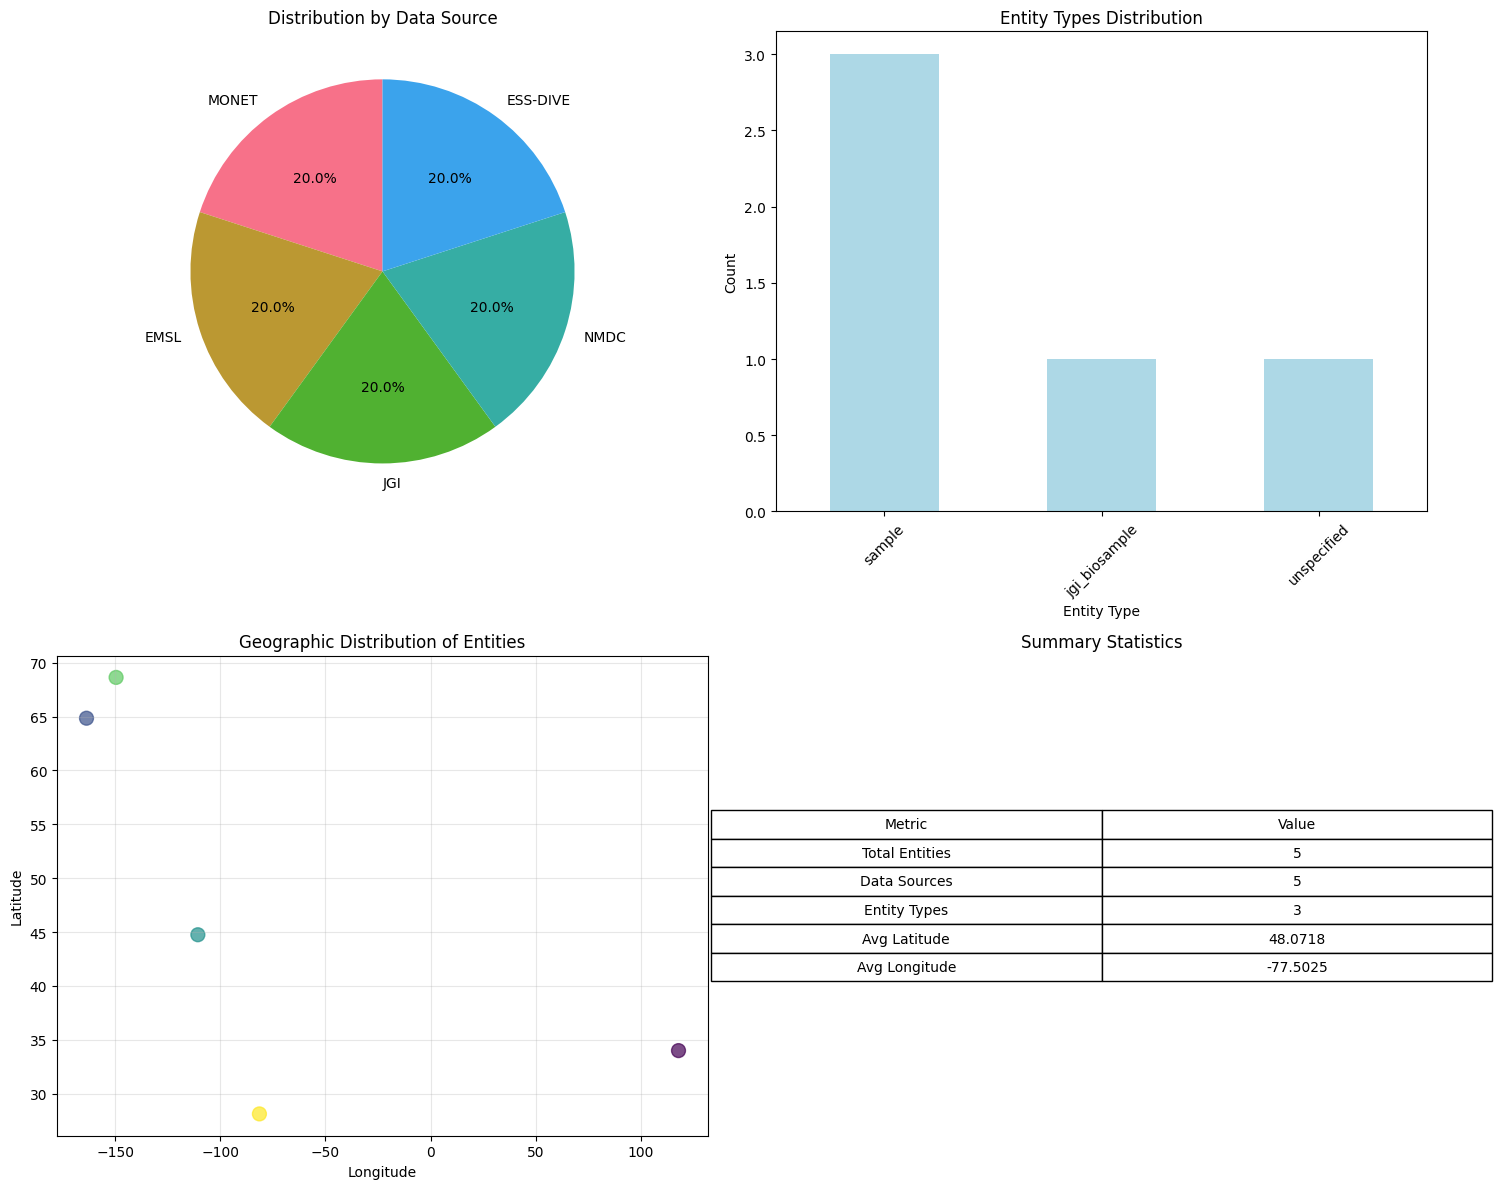

In [6]:
# Basic statistics about the data
print("📊 DATASET OVERVIEW")
print("=" * 50)
print(f"Total entities: {len(entities_df)}")
print(f"Data sources: {entities_df['ber_data_source'].nunique()}")
print(f"Unique entity types: {entities_df['entity_types'].nunique()}")

print("\n📍 GEOGRAPHIC DISTRIBUTION")
print("=" * 50)
print(f"Latitude range: {entities_df['latitude'].min():.4f} to {entities_df['latitude'].max():.4f}")
print(f"Longitude range: {entities_df['longitude'].min():.4f} to {entities_df['longitude'].max():.4f}")

print("\n🏷️ DATA SOURCES")
print("=" * 50)
source_counts = entities_df['ber_data_source'].value_counts()
for source, count in source_counts.items():
    print(f"   {source}: {count} entities")

print("\n🔖 ENTITY TYPES")
print("=" * 50)
type_counts = entities_df['entity_types'].value_counts()
for entity_type, count in type_counts.items():
    print(f"   {entity_type}: {count} entities")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Data sources pie chart
axes[0, 0].pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Distribution by Data Source')

# 2. Entity types bar chart
type_counts.plot(kind='bar', ax=axes[0, 1], color='lightblue')
axes[0, 1].set_title('Entity Types Distribution')
axes[0, 1].set_xlabel('Entity Type')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Geographic scatter plot
scatter = axes[1, 0].scatter(entities_df['longitude'], entities_df['latitude'], 
                            c=pd.Categorical(entities_df['ber_data_source']).codes, 
                            alpha=0.7, s=100)
axes[1, 0].set_title('Geographic Distribution of Entities')
axes[1, 0].set_xlabel('Longitude')
axes[1, 0].set_ylabel('Latitude')
axes[1, 0].grid(True, alpha=0.3)

# 4. Data summary table
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
summary_data = [
    ['Total Entities', len(entities_df)],
    ['Data Sources', entities_df['ber_data_source'].nunique()],
    ['Entity Types', entities_df['entity_types'].nunique()],
    ['Avg Latitude', f"{entities_df['latitude'].mean():.4f}"],
    ['Avg Longitude', f"{entities_df['longitude'].mean():.4f}"],
]
table = axes[1, 1].table(cellText=summary_data, 
                        colLabels=['Metric', 'Value'],
                        cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1, 1].set_title('Summary Statistics')

plt.tight_layout()
plt.show()

In [7]:
# Drop rows with missing coordinates
coords_df = entities_df.dropna(subset=['latitude', 'longitude'])

# Calculate the center of the map
center_lat = coords_df['latitude'].mean()
center_lng = coords_df['longitude'].mean()

# Create the map
m = folium.Map(location=[center_lat, center_lng], zoom_start=5)

# Add a marker for each entity
for _, row in coords_df.iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=f"{row['name']} ({row['id']})"
    ).add_to(m)

# Display the map
m

## 6. Geospatial Queries

Let's demonstrate the geospatial query capabilities of the BERtron client.

🌍 GEOSPATIAL QUERY EXAMPLES

🔍 Searching for entities within 100km of Orlando, FL
   Center coordinates: 28.5383, -81.3792


   Found: 1 entities
   Query type: geospatial_nearby
   Metadata: {'center': {'latitude': 28.5383, 'longitude': -81.3792}, 'radius_meters': 100000}

📍 Nearby entities:
   1. DSNY_CoreB_TOP
      Location: 28.1258, -81.4342
      Source: NMDC

📦 BOUNDING BOX QUERY
Searching within bounding box:
   Southwest: 25.0, -85.0
   Northeast: 31.0, -80.0
   Found: 1 entities
   Query type: geospatial_bounding_box


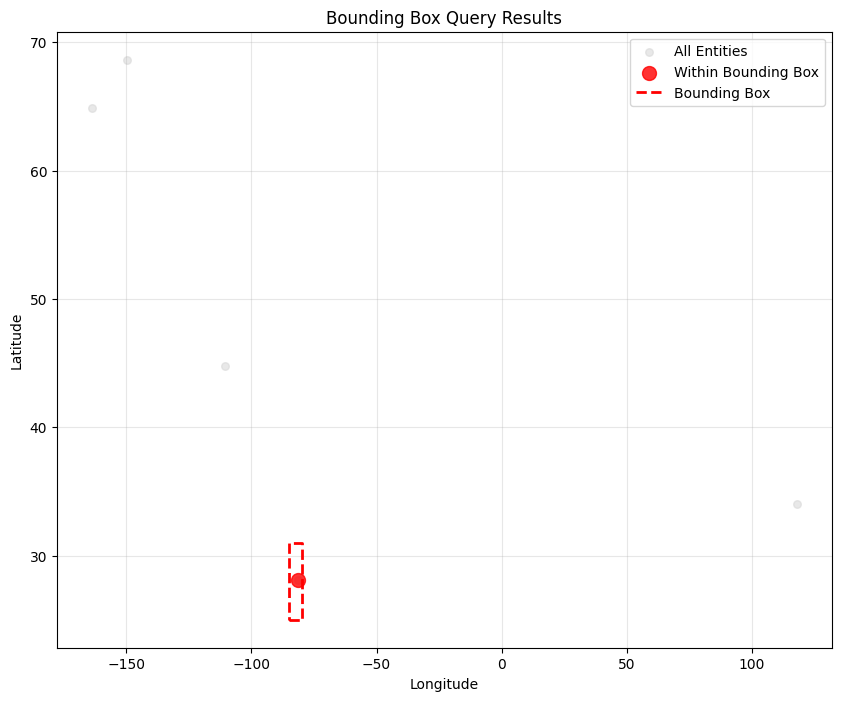

In [8]:
# Example 1: Find entities near a specific location (Florida coordinates)
print("🌍 GEOSPATIAL QUERY EXAMPLES")
print("=" * 50)

# Find entities within 100km of Orlando, Florida
orlando_lat, orlando_lng = 28.5383, -81.3792
radius_km = 100

print(f"\n🔍 Searching for entities within {radius_km}km of Orlando, FL")
print(f"   Center coordinates: {orlando_lat}, {orlando_lng}")

nearby_entities = client.get_entities_in_region(orlando_lat, orlando_lng, radius_km)
print(f"   Found: {nearby_entities.count} entities")

if nearby_entities.entities:
    nearby_df = entities_to_dataframe(nearby_entities.entities)
    print(f"   Query type: {nearby_entities.query_type}")
    print(f"   Metadata: {nearby_entities.metadata}")
    
    print("\n📍 Nearby entities:")
    for i, entity in enumerate(nearby_entities.entities):
        coords = entity.coordinates
        print(f"   {i+1}. {entity.name}")
        print(f"      Location: {coords.latitude:.4f}, {coords.longitude:.4f}")
        print(f"      Source: {entity.ber_data_source}")
        print()

# Example 2: Bounding box query
print("📦 BOUNDING BOX QUERY")
print("=" * 30)

# Define a bounding box around Florida
sw_lat, sw_lng = 25.0, -85.0  # Southwest corner
ne_lat, ne_lng = 31.0, -80.0  # Northeast corner

print(f"Searching within bounding box:")
print(f"   Southwest: {sw_lat}, {sw_lng}")
print(f"   Northeast: {ne_lat}, {ne_lng}")

bbox_entities = client.find_entities_in_bounding_box(sw_lat, sw_lng, ne_lat, ne_lng)
print(f"   Found: {bbox_entities.count} entities")

if bbox_entities.entities:
    bbox_df = entities_to_dataframe(bbox_entities.entities)
    print(f"   Query type: {bbox_entities.query_type}")
    
    # Visualize the bounding box query results
    plt.figure(figsize=(10, 8))
    
    # Plot all entities in light color
    plt.scatter(entities_df['longitude'], entities_df['latitude'], 
                c='lightgray', alpha=0.5, s=30, label='All Entities')
    
    # Plot bounding box entities in bright color
    plt.scatter(bbox_df['longitude'], bbox_df['latitude'], 
                c='red', s=100, alpha=0.8, label='Within Bounding Box')
    
    # Draw the bounding box
    bbox_x = [sw_lng, ne_lng, ne_lng, sw_lng, sw_lng]
    bbox_y = [sw_lat, sw_lat, ne_lat, ne_lat, sw_lat]
    plt.plot(bbox_x, bbox_y, 'r--', linewidth=2, label='Bounding Box')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Bounding Box Query Results')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("   No entities found in bounding box")

## 7. Filtered Queries and Data Source Analysis

Let's explore filtering entities by different criteria and analyze the results.

In [9]:
# Query entities by data source
print("🏢 QUERYING BY DATA SOURCE")
print("=" * 40)

data_sources = entities_df['ber_data_source'].unique()
source_dataframes = {}

for source in data_sources:
    try:
        entities_response = client.find_entities_by_source(source)
        source_df = entities_to_dataframe(entities_response.entities)
        source_dataframes[source] = source_df
        
        print(f"\n📊 {source} Data Source:")
        print(f"   Entities found: {entities_response.count}")
        if entities_response.entities:
            print(f"   Sample entity: {entities_response.entities[0].name}")
            print(f"   Entity types: {set(source_df['entity_types'].dropna())}")
            
    except BertronAPIError as e:
        print(f"   Error querying {source}: {e}")

# Query entities by entity type
print(f"\n🏷️ QUERYING BY ENTITY TYPE")
print("=" * 40)

entity_types = ['sample', 'sequence', 'biodata', 'taxon']
type_dataframes = {}

for entity_type in entity_types:
    try:
        entities_response = client.find_entities_by_entity_type(entity_type)
        type_df = entities_to_dataframe(entities_response.entities)
        type_dataframes[entity_type] = type_df
        
        print(f"\n🔖 '{entity_type}' entities:")
        print(f"   Found: {entities_response.count}")
        if entities_response.entities:
            sources = set(type_df['ber_data_source'].dropna())
            print(f"   Data sources: {sources}")
            
    except BertronAPIError as e:
        print(f"   Error querying {entity_type}: {e}")

# Advanced query using MongoDB syntax
print(f"\n🔍 ADVANCED MONGODB QUERY")
print("=" * 40)

try:
    # Find entities with specific characteristics
    advanced_query = {
        "filter": {
            "ber_data_source": "NMDC",
            "entity_type": {"$in": ["sample"]}
        },
        "limit": 10
    }
    
    advanced_response = client.find_entities(
        filter_dict=advanced_query["filter"],
        limit=advanced_query["limit"]
    )
    
    print(f"Advanced query results: {advanced_response.count} entities")
    if advanced_response.entities:
        advanced_df = entities_to_dataframe(advanced_response.entities)
        print(f"Sample result: {advanced_response.entities[0].name}")
        
except BertronAPIError as e:
    print(f"Advanced query error: {e}")

# Search by name pattern
print(f"\n🔤 NAME PATTERN SEARCH")
print("=" * 40)

try:
    # Search for entities with specific name patterns
    name_patterns = ["DSNY", "Core", "sample"]
    
    for pattern in name_patterns:
        search_response = client.search_entities_by_name(pattern, case_sensitive=False)
        print(f"Pattern '{pattern}': {search_response.count} matches")
        
        if search_response.entities:
            for entity in search_response.entities[:2]:  # Show first 2 matches
                print(f"   • {entity.name} ({entity.ber_data_source})")
                
except BertronAPIError as e:
    print(f"Name search error: {e}")

🏢 QUERYING BY DATA SOURCE

📊 MONET Data Source:
   Entities found: 1
   Sample entity: MONet Core 60920_7
   Entity types: {'sample'}

📊 EMSL Data Source:
   Entities found: 1
   Sample entity: EMSL Sample c9405190-e962-4ba5-93f0-e3ff499f4488
   Entity types: {'sample'}

📊 JGI Data Source:
   Entities found: 1
   Sample entity: Hot spring microbial communities from Yellowstone National Park, Wyoming, USA - YNP2   Nymph Lake 10
   Entity types: {'jgi_biosample'}

📊 NMDC Data Source:
   Entities found: 1
   Sample entity: DSNY_CoreB_TOP
   Entity types: {'sample'}

📊 ESS-DIVE Data Source:
   Entities found: 1
   Sample entity: NGEE Arctic Council Site, Mile Marker 71, Alaska
   Entity types: {'unspecified'}

🏷️ QUERYING BY ENTITY TYPE

🔖 'sample' entities:
   Found: 3
   Data sources: {'MONET', 'NMDC', 'EMSL'}

🔖 'sequence' entities:
   Found: 0

🔖 'biodata' entities:
   Found: 0

🔖 'taxon' entities:
   Found: 0

🔍 ADVANCED MONGODB QUERY
Advanced query results: 1 entities
Sample result: 

## 8. Detailed Entity Examination

Let's examine individual entities in detail and explore the pydantic validation features.

In [10]:
# Get a specific entity by ID for detailed examination
if all_entities_response.entities and all_entities_response.entities[0].id:
    entity_id = all_entities_response.entities[0].id
    
    print(f"🔍 DETAILED ENTITY EXAMINATION")
    print("=" * 50)
    print(f"Retrieving entity with ID: {entity_id}")
    
    try:
        detailed_entity = client.get_entity_by_id(entity_id)
        
        print(f"\n📋 ENTITY DETAILS")
        print("-" * 30)
        print(f"Type: {type(detailed_entity)}")
        print(f"Name: {detailed_entity.name}")
        print(f"ID: {detailed_entity.id}")
        print(f"URI: {detailed_entity.uri}")
        print(f"Data Source: {detailed_entity.ber_data_source}")
        print(f"Entity Types: {detailed_entity.entity_type}")
        print(f"Description: {detailed_entity.description}")
        
        print(f"\n🌍 COORDINATE DETAILS")
        print("-" * 30)
        coords = detailed_entity.coordinates
        print(f"Latitude: {coords.latitude}")
        print(f"Longitude: {coords.longitude}")
        
        if coords.elevation:
            print(f"Elevation: {coords.elevation.numeric_value} {coords.elevation.unit}")
        if coords.depth:
            depth_val = coords.depth.numeric_value
            depth_min = coords.depth.minimum_numeric_value
            depth_max = coords.depth.maximum_numeric_value
            depth_unit = coords.depth.unit
            
            if depth_min is not None and depth_max is not None:
                print(f"Depth: {depth_min} - {depth_max} {depth_unit}")
            elif depth_val is not None:
                print(f"Depth: {depth_val} {depth_unit}")
        
        print(f"\n🔗 ADDITIONAL INFORMATION")
        print("-" * 30)
        print(f"Alternative IDs: {detailed_entity.alt_ids}")
        print(f"Alternative Names: {detailed_entity.alt_names}")
        print(f"Collections: {detailed_entity.part_of_collection}")
        
        # Demonstrate pydantic validation
        print(f"\n✅ PYDANTIC VALIDATION FEATURES")
        print("-" * 30)
        print(f"Model validation: {hasattr(detailed_entity, 'model_validate')}")
        print(f"JSON export: {hasattr(detailed_entity, 'model_dump')}")
        print(f"Schema generation: {hasattr(detailed_entity, 'model_json_schema')}")
        
        # Export to JSON
        entity_json = detailed_entity.model_dump()
        print(f"JSON keys: {list(entity_json.keys())}")
        
        # Create a DataFrame with just this entity for demonstration
        single_entity_df = entities_to_dataframe([detailed_entity])
        print(f"\nSingle entity DataFrame shape: {single_entity_df.shape}")
        display(single_entity_df)
        
    except BertronAPIError as e:
        print(f"Error retrieving entity: {e}")
else:
    print("⚠️ No entity ID available for detailed examination")

# Demonstrate error handling
print(f"\n❌ ERROR HANDLING DEMONSTRATION")
print("=" * 50)

try:
    # Try to get a non-existent entity
    fake_entity = client.get_entity_by_id("fake-id-12345")
except BertronAPIError as e:
    print(f"✅ Caught expected API error: {e}")
except Exception as e:
    print(f"❌ Unexpected error: {e}")

# Summary statistics for the entire dataset
print(f"\n📊 FINAL DATASET SUMMARY")
print("=" * 50)
print(f"Total entities processed: {len(entities_df)}")
print(f"DataFrame memory usage: {entities_df.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"Data types:")
for col, dtype in entities_df.dtypes.items():
    print(f"   {col}: {dtype}")

# Show the complete DataFrame info
print(f"\nDataFrame Info:")
entities_df.info()

🔍 DETAILED ENTITY EXAMINATION
Retrieving entity with ID: MONET:072e85bf-4a43-4212-83dc-108bb262620c

📋 ENTITY DETAILS
------------------------------
Type: <class 'schema.datamodel.bertron_schema_pydantic.Entity'>
Name: MONet Core 60920_7
ID: MONET:072e85bf-4a43-4212-83dc-108bb262620c
URI: https://sc-data.emsl.pnnl.gov/monet
Data Source: MONET
Entity Types: ['sample']
Description: None

🌍 COORDINATE DETAILS
------------------------------
Latitude: 68.633578
Longitude: -149.632826
Elevation: 722.613 unknown

🔗 ADDITIONAL INFORMATION
------------------------------
Alternative IDs: None
Alternative Names: None
Collections: None

✅ PYDANTIC VALIDATION FEATURES
------------------------------
Model validation: True
JSON export: True
Schema generation: True
JSON keys: ['ber_data_source', 'coordinates', 'entity_type', 'description', 'id', 'name', 'alt_ids', 'alt_names', 'part_of_collection', 'uri', 'properties']

Single entity DataFrame shape: (1, 15)


,id,name,uri,ber_data_source,description,entity_types,latitude,longitude,elevation,elevation_unit,depth,depth_unit,alt_ids_count,alt_names_count,collections_count
0,MONET:072e85bf-4a43-4212-83dc-108bb262620c,MONet Core 60920_7,https://sc-data.emsl.pnnl.gov/monet,MONET,None,sample,68.633578,-149.632826,722.613,unknown,None,None,0,0,0


ERROR:bertron_client:API request failed: 404 Client Error: Not Found for url: https://bertron-api.bertron.production.svc.spin.nersc.org/bertron/fake-id-12345



❌ ERROR HANDLING DEMONSTRATION
✅ Caught expected API error: API request failed: 404 Client Error: Not Found for url: https://bertron-api.bertron.production.svc.spin.nersc.org/bertron/fake-id-12345

📊 FINAL DATASET SUMMARY
Total entities processed: 5
DataFrame memory usage: 3.14 KB
Data types:
   id: object
   name: object
   uri: object
   ber_data_source: object
   description: object
   entity_types: object
   latitude: float64
   longitude: float64
   elevation: float64
   elevation_unit: object
   depth: object
   depth_unit: object
   alt_ids_count: int64
   alt_names_count: int64
   collections_count: int64

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5 non-null      object 
 1   name               5 non-null      object 
 2   uri                5 non-null      object 
 3   ber_data_source

## 9. Conclusion

This notebook has demonstrated the comprehensive functionality of the BERtron Python client, including:

### ✅ **Features Demonstrated**
- **Client Initialization**: Connected to BERtron API and tested health status
- **Data Retrieval**: Retrieved all entities using the `get_all_entities()` method
- **DataFrame Conversion**: Converted pydantic Entity objects to pandas DataFrames for analysis
- **Data Analysis**: Performed statistical analysis and created visualizations
- **Map Visualization**: Displayed samples on a map
- **Geospatial Queries**: Used both nearby searches and bounding box queries
- **Filtered Queries**: Filtered by data source, entity type, and name patterns
- **Advanced Queries**: Demonstrated MongoDB-style query syntax
- **Entity Details**: Examined individual entities with full type safety
- **Error Handling**: Showed proper exception handling for API errors

### 🚀 **Key Benefits**
- **Type Safety**: Full pydantic validation ensures data integrity
- **Easy Integration**: Simple conversion to pandas for data science workflows  
- **Rich Querying**: Support for geospatial, filtered, and advanced queries
- **Structured Data**: Well-organized coordinates and metadata
- **Error Resilience**: Robust error handling for production use

### 🔗 **Next Steps**
- Export data to different formats (CSV, JSON, etc.)
- Integrate with other geospatial libraries (folium, geopandas)
- Create more complex analytical workflows
- Build interactive dashboards using the client

The BERtron client successfully bridges the gap between the BER data ecosystem and modern Python data science tools! 🎉